# Lending Club Loan Default Prediction

Created by Yuxi Chen on 10/20/2018

Predict default loan. Binary Classification problem.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
import math
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [3]:
location='/Users/yuxi/Downloads/loan.csv'
my_data=pd.read_csv(location)
df=my_data
df.shape

(887379, 74)

# Feature Engineering
## Missing Value Imputation

In [4]:
#sns.heatmap(my_data.isnull(),cbar=False,yticklabels=False)

Impute missing values of annual income

In [5]:
# fill the NA values of annual income with its median, as its dist'n is right skewed
df['annual_inc'] = df['annual_inc'].fillna(value=df['annual_inc'].median())
len(df['annual_inc'])-df['annual_inc'].count()

0

** TO BE IMPROVED ** - KNN?

In [6]:
df['total_acc'] = df['total_acc'].fillna(value=df['total_acc'].median())
df['tot_cur_bal'] = df['tot_cur_bal'].fillna(value=df['tot_cur_bal'].median())
df['open_acc'] = df['open_acc'].fillna(value=df['open_acc'].median())

In [7]:
df['emp_length'].fillna(value='n/a',inplace=True)

## Remove useless features
* Remove most of loan payment related features, since payments were made after interest rates were determined. Hence, they should not be used to predict interest rate.  
* Remove features with unique value per row and with same value across rows (no variance): policy_code, id, member_id, url  
* Remove redundant features: dti_joint, annual_income_joint, and application_type which indicates wheter it's a joint loan, and verification_status_joint
* Drop the features with more than 80% values missing
* Remove emp_title, desc, title, which require text mining
* Remove zip_code, which require external information

In [8]:
payment_related = ['installment','funded_amnt','funded_amnt_inv','last_pymnt_amnt','last_pymnt_d','next_pymnt_d',\
                   'recoveries','total_pymnt','total_pymnt_inv','total_rec_int','total_rec_late_fee','total_rec_prncp',\
                   'collection_recovery_fee','out_prncp','out_prncp_inv']
df.drop(payment_related,axis=1,inplace=True)

In [9]:
df['policy_code'].unique() # drop policy code since all loans have policy_code=1
df.drop('policy_code',axis=1,inplace=True)

In [10]:
df.drop(['id','member_id','url'],axis=1,inplace=True)

In [11]:
df['dti_2'] = df['dti_joint'].fillna(df['dti'])
df['annual_inc_2'] = df['annual_inc_joint'].fillna(df['annual_inc'])

In [12]:
df.drop(['dti','dti_joint','annual_inc','annual_inc_joint'],axis=1,inplace=True)

In [13]:
# hence also drop application type and verification_status_joint
df.drop('application_type',axis=1,inplace=True)
df.drop('verification_status_joint',axis=1,inplace=True)

In [14]:
# Drop the features with more than 80% values missing
df = df.dropna(axis=1,thresh=len(df)*0.8)
na_cols = df.shape[0]-df.count()
na_cols[na_cols>0]
df.shape

(887379, 33)

In [15]:
df.drop(['emp_title','title','zip_code'],axis=1,inplace=True)

In [16]:
# check number of features left
df.shape

(887379, 30)

## Collapse levels of the categorical features w/ too many levels

 **ADDR_STATE**: 51 levels

In [17]:
state_int_mean=df.groupby('addr_state').mean()['int_rate']
low=[]
medium_low=[]
medium_high=[]
high=[]
for x in df['addr_state'].unique():
    if state_int_mean[x] <= state_int_mean.describe()['25%']:
        low.append(x)
    elif state_int_mean[x]>state_int_mean.describe()['25%'] and state_int_mean[x]<=state_int_mean.mean():
        medium_low.append(x)
    elif state_int_mean[x]>state_int_mean.mean() and state_int_mean[x]<=state_int_mean.describe()['75%']:
        medium_high.append(x)
    else:
        high.append(x)

def collapse(x): 
    if x in low:
        return 'low'
    if x in medium_low:
        return 'medium_low'
    if x in medium_high:
        return 'medium_high'
    else:
        return 'high'

df['addr_state_2']=df['addr_state'].apply(collapse)

** LOAN PURPOSE **  
From EDA, credit card, car and educational loans have lower interest rate on average. Collapse these three into one level and the rest into one.

In [18]:
# one hot: 0 for credit_card, car, educational, 1 for the others
df['purpose_2'] = df['purpose'].apply(lambda x: 0 if x in ['credit_card', 'car', 'educational'] else 1)

#### HOME OWNERSHIP

In [19]:
# merge 'ANY','NONE' into 'OTHER'
df['home_ownership'] = df['home_ownership'].apply(lambda x: 'OTHER' if x in ['ANY','NONE'] else x)

## Create new features

** CREDIT HISTORY: ** issue_d - earliest_cr_line

In [20]:
d1=pd.to_datetime(df['earliest_cr_line'],format='%b-%Y')
d2=pd.to_datetime(df['issue_d'],format='%b-%Y')
df['credit_history']=(d2-d1).astype('timedelta64[D]')
df['credit_history'].fillna(value=0,inplace=True)
df.drop('earliest_cr_line',axis=1,inplace=True)

In [21]:
#df[df['delinq_2yrs'].isnull()].index
#(len(df)-df.count())[(len(df)-df.count())==29]
#df[df['delinq_2yrs'].isnull()].index==my_data[my_data['earliest_cr_line'].isnull()].index

#When the customer doesn't have an earliest credit line, these columns all have NA values
for i in ['delinq_2yrs','inq_last_6mths','pub_rec','acc_now_delinq']:
    df[i].fillna(value=0,inplace=True)

## RESPONSE VARIABLE: Loan Status

In [22]:
df['loan_status'] = df['loan_status'].str.replace('Does not meet the credit policy. Status.', '')
# drop vague staus
df = df[(df['loan_status']!='Current') & (df['loan_status']!='Issued')]

**0** for bad loan: 'Charged Off', 'Default', 'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)'  
**1** for good loan: 'Fully Paid'

In [25]:
df['loan_status'] = df['loan_status'].apply(lambda x: 0 if x=='Fully Paid' else 1)
df['loan_status'].value_counts()

0    209711
1     67429
Name: loan_status, dtype: int64

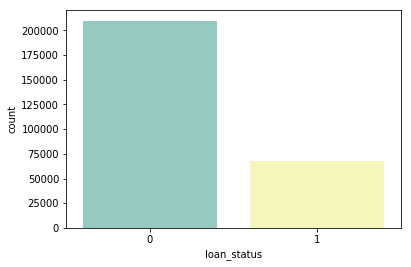

In [26]:
sns.countplot(x='loan_status',data=df,palette='Set3')
plt.show()

## Transform skewed features

In [27]:
#ls=['annual_inc_2', 'dti_2', 'loan_amnt', 'total_acc', 'tot_cur_bal', 'open_acc','credit_history']
numeric_col = [i for i in df if df[i].dtype=='float64']
for i in numeric_col:
    df[i]=stats.boxcox(df[i]+0.01)[0]

## Standardize numeric features

In [28]:
df[numeric_col]=preprocessing.scale(df[numeric_col])

#### Select a subset of features

In [29]:
#select=['loan_amnt','term','int_rate','grade','home_ownership','verification_status','pymnt_plan',\
#        'open_acc','total_acc','tot_cur_bal','dti_2','annual_inc_2','addr_state_2','purpose_2','credit_history']
# select only cols w/o missing vals -- needs improvement
non_NA = [i for i in df if len(df[i])-df[i].count()==0]
train_sub=df[non_NA]
train_sub.drop(['purpose','addr_state','issue_d','sub_grade'],axis=1,inplace=True)

## One hot encoding for categorical variables

In [30]:
cate = train_sub.select_dtypes(include=['object']).columns
dummies = pd.get_dummies(train_sub[cate],prefix=cate,drop_first=True)
train_sub.drop(cate,axis=1,inplace=True)
train_sub = pd.concat([train_sub,dummies],axis=1)

In [31]:
X=train_sub.drop('loan_status',axis=1)
y=train_sub['loan_status']

# Modeling

## Train test split, 5-fold cv for training set

In [255]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)
k_fold = KFold(5,random_state=0)

## Baseline - Logistic Regression w/ default threshold

In [256]:
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print result.summary2()

Optimization terminated successfully.
         Current function value: 0.509854
         Iterations 6
                                   Results: Logit
Model:                    Logit                  No. Iterations:         6.0000     
Dependent Variable:       loan_status            Pseudo R-squared:       0.081      
Date:                     2018-10-25 21:41       AIC:                    197905.1217
No. Observations:         193998                 BIC:                    198332.4971
Df Model:                 41                     Log-Likelihood:         -98911.    
Df Residuals:             193956                 LL-Null:                -1.0764e+05
Converged:                1.0000                 Scale:                  1.0000     
------------------------------------------------------------------------------------
                                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------------

## Regularized Logistic Regression - L2

In [257]:
logmod = LogisticRegression(solver='saga')
logmod.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

In [258]:
pred1=logmod.predict(X_test)

In [259]:
print classification_report(y_test,pred1)

              precision    recall  f1-score   support

           0       0.77      0.97      0.86     62912
           1       0.55      0.12      0.19     20230

   micro avg       0.76      0.76      0.76     83142
   macro avg       0.66      0.54      0.53     83142
weighted avg       0.72      0.76      0.70     83142



In [260]:
pd.DataFrame(confusion_matrix(y_test,pred1),columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])

,pred_0,pred_1
true_0,60992,1920
true_1,17840,2390


In [261]:
#check deviance, AIC

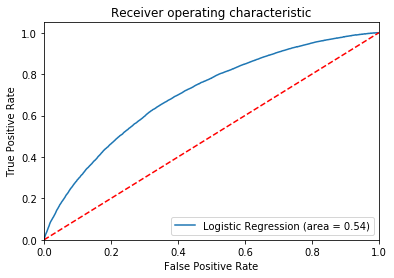

In [262]:
#ROC curve
logit_roc_auc = roc_auc_score(y_test, logmod.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logmod.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Regularized Logistic Regression - L1

In [270]:
lambdas=np.logspace(-5,5,10)
for c in 1/lambdas:
    logmod=LogisticRegression(penalty='l1',C=c,random_state=0, solver='saga').fit(X_train,y_train)
    logit_roc_auc = roc_auc_score(y_test, logmod.predict(X_test))
    print 'lambda:',1/c,' AUC:',logit_roc_auc

lambda: 1e-05  AUC: 0.543712414054246
lambda: 0.0001291549665014884  AUC: 0.543712414054246
lambda: 0.001668100537200059  AUC: 0.543712414054246
lambda: 0.021544346900318846  AUC: 0.543712414054246
lambda: 0.2782559402207126  AUC: 0.5437618455915668
lambda: 3.5938136638046254  AUC: 0.5437283092729642
lambda: 46.41588833612782  AUC: 0.5433153070186245
lambda: 599.4842503189421  AUC: 0.534225544872069
lambda: 7742.636826811277  AUC: 0.5
lambda: 99999.99999999999  AUC: 0.5


## Over-sampling with SMOTE

In [38]:
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['loan_status'])

In [37]:
# Check the numbers
print("length of oversampled data is ",len(os_data_X))
print("Number of good loan in oversampled data",len(os_data_y[os_data_y['loan_status']==0]))
print("Number of bad loan",len(os_data_y[os_data_y['loan_status']==1]))
print("Proportion of good loan data in oversampled data is ",float(len(os_data_y[os_data_y['loan_status']==0]))/len(os_data_X))
print("Proportion of bad loan data in oversampled data is ",float(len(os_data_y[os_data_y['loan_status']==1]))/len(os_data_X))

('length of oversampled data is ', 293552)
('Number of good loan in oversampled data', 146776)
('Number of bad loan', 146776)
('Proportion of good loan data in oversampled data is ', 0.5)
('Proportion of bad loan data in oversampled data is ', 0.5)


## Retry L2

In [40]:
logmod = LogisticRegression(penalty='l2',solver='saga')
logmod.fit(os_data_X,os_data_y)
pred4=logmod.predict(X_test)

In [41]:
print classification_report(y_test,pred4)

              precision    recall  f1-score   support

           0       0.85      0.63      0.73     62935
           1       0.37      0.66      0.47     20207

   micro avg       0.64      0.64      0.64     83142
   macro avg       0.61      0.65      0.60     83142
weighted avg       0.74      0.64      0.66     83142



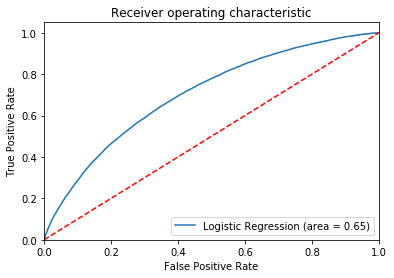

In [42]:
logit_roc_auc = roc_auc_score(y_test, logmod.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logmod.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [44]:
lambdas=np.logspace(-5,5,10)
for c in 1/lambdas:
    logmod=LogisticRegression(penalty='l2',C=c,random_state=0, solver='saga').fit(os_data_X,os_data_y)
    logit_roc_auc = roc_auc_score(y_test, logmod.predict(X_test))
    print 'lambda:',1/c,' AUC:',logit_roc_auc

lambda: 1e-05  AUC: 0.6477105758529433
lambda: 0.0001291549665014884  AUC: 0.6477105758529433
lambda: 0.001668100537200059  AUC: 0.6477105758529433
lambda: 0.021544346900318846  AUC: 0.6477185205577976
lambda: 0.2782559402207126  AUC: 0.6476619978377522
lambda: 3.5938136638046254  AUC: 0.6475153540061129
lambda: 46.41588833612782  AUC: 0.6475114714921112
lambda: 599.4842503189421  AUC: 0.647330499159708
lambda: 7742.636826811277  AUC: 0.6471490400878279
lambda: 99999.99999999999  AUC: 0.6452900951359043


## Summary

In summary, since there were not too many useful features in the data set, regularization as a method to deal with overfitting and multicollinearity can't improve model performance. However, after up-sampling the data using SMOTE, I was able to improve AUC by 0.11.

Should use more advanced models such as random forest and XGboost in the future, since the decision boundary is highly likely non-linear.